In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/final project/donnees-relatives-a-lepidemie-de-covid-19-en-france-vue-densemble.csv', sep=';', parse_dates=['date'], dayfirst=True)
df.set_index('date',inplace=True)
df.head() #sample of head of dataset

,tot_positive,tot_death_hosp,tot_death_ephad,tot_positive_ephad,tot_icu,tot_hosp,tot_recovered,count_new_hosp,count_new_icu,n_dose1,n_cum_dose1
date,,,,,,,,,,,
2020-03-02,191,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-03-03,212,4,NaN,NaN,NaN,NaN,12.0,NaN,NaN,0,0
2020-03-04,285,4,NaN,NaN,15.0,NaN,NaN,NaN,NaN,0,0
2020-03-05,423,7,NaN,NaN,23.0,NaN,NaN,NaN,NaN,0,0
2020-03-06,613,9,NaN,NaN,39.0,NaN,NaN,NaN,NaN,0,0


In [5]:
df = df[['count_new_hosp', 'n_dose1', 'n_cum_dose1']]
df.sort_index(inplace=True)
df.head()

,count_new_hosp,n_dose1,n_cum_dose1
date,,,
2020-03-02,NaN,0,0
2020-03-03,NaN,0,0
2020-03-04,NaN,0,0
2020-03-05,NaN,0,0
2020-03-06,NaN,0,0


In [4]:
df.shape #the total dataset with 337 rows of data

(354, 3)

In [6]:
# split data into two parts. First part without vaccine taking place, second part with vaccine
for i, j in enumerate(df.index):
  if '2020-12-27' in str(j):
    df_1 = df.iloc[:i, :]
  if '2021-01-10' in str(j):
    df_2 = df.iloc[i:len(df.index), :]

df_1 = df_1[['count_new_hosp']]
df_1 = df_1.dropna()
df_2 = df_2.dropna()
print(df_1.shape)
print(df_2.shape)

(283, 1)
(40, 3)


# Predict before vaccination

In [30]:
# split dataset to training dataset and test dataset
split_len = round((df_1.shape[0])*.75)
training_data = df_1[:split_len]
testing_data = df_1[split_len:]
# training_data = training_data.values
# testing_data = testing_data['count_new_hosp'].values
print(training_data.shape)
print(testing_data.shape)

(212, 1)
(71, 1)


In [9]:
# normalisation
# create time sequence for the model
# reshape the data

def process(data, step):

  x_train = []
  y_train = []
  for i in range(step,len(data)):
      x_train.append(data[i-step:i])
      y_train.append(data[i])

  #convert the x_train and y_train  to numppy array
  x_train, y_train = np.array(x_train), np.array(y_train)
  #reshape the data
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
  print(x_train.shape)
  print(y_train.shape)
  return x_train, y_train

In [32]:
from sklearn.preprocessing import MinMaxScaler

# build the data
step = 5
#normalise the data
scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_test = MinMaxScaler(feature_range=(0,1))
training_data_1 = scaler_train.fit_transform(training_data[['count_new_hosp']])
testing_data_1 = scaler_test.fit_transform(testing_data[['count_new_hosp']])

x_train, y_train = process(training_data_1, step)
x_test, y_test = process(testing_data_1, step)

(207, 5, 1)
(207, 1)
(66, 5, 1)
(66, 1)


In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(step, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
_________________________________________________________________


In [39]:
adam = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0514 - val_loss: 0.0679
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.0269
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0274
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0253
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0251
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0262
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0242
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0239
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0231
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0228
Epoch 11/100
7/7 [==========

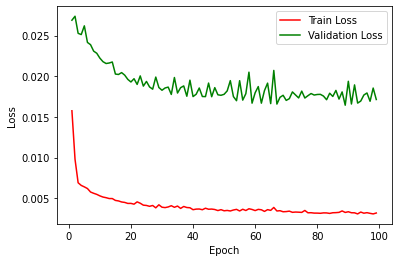

In [40]:
# Model results of said fitting, displayed in a plot
df_results = pd.DataFrame.from_dict(history.history)
df_results = df_results.iloc[1:,]
plt.plot(df_results['loss'], color='red', label=('Train Loss'))
plt.plot(df_results['val_loss'], color='green', label=('Validation Loss'))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [41]:
# function to predict future
def future_num_1(step, df1, model, num_date):
  x = []
  scaler = MinMaxScaler(feature_range=(0,1))
  df = scaler.fit_transform(df1[['count_new_hosp']])

  x = df[len(df)-step:len(df)]
  x = np.array(x)
  x = np.reshape(x,(1,x.shape[0],1))
  y = model.predict(x)

  for i in range(num_date):
      x = np.delete(x, 0, axis=1)
      temp = y[y.shape[0]-1]
      temp = np.reshape(temp,(1,1,1))
      x = np.append(x, temp, axis=1)
      y = np.append(y, model.predict(x))

  y = scaler.inverse_transform([y])
  return y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


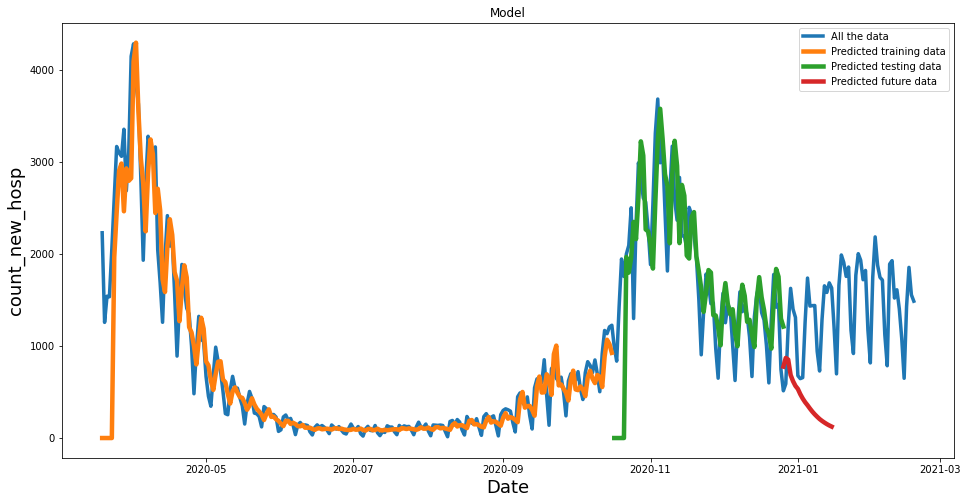

In [42]:
predict_data_train = df_1[:split_len]
predictions_x_train = np.zeros(step)
predictions_x_train = np.append(predictions_x_train, scaler_train.inverse_transform(model.predict(x_train)))
predict_data_train['predict_x_train'] = list(predictions_x_train)

predict_data_test = df_1[split_len:]
predictions_x_test = np.zeros(step)
predictions_x_test = np.append(predictions_x_test, scaler_test.inverse_transform(model.predict(x_test)))
predict_data_test['predict_x_test'] = list(predictions_x_test)

num_date = 20
futuren_predict = future_num_1(step, df_1, model, num_date)
rng = pd.date_range(df_1.index[len(df_1.index)-1], periods=num_date+1, freq='D')
prediction_future = pd.DataFrame({ 'date': rng, 'future_predict': list(futuren_predict[0])})
prediction_future.set_index('date',inplace=True)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('count_new_hosp' ,fontsize=18)
plt.plot(df['count_new_hosp'],linewidth=3.5, label=('All the data'))
plt.plot(predict_data_train['predict_x_train'],linewidth=4.5, label=('Predicted training data'))
plt.plot(predict_data_test['predict_x_test'],linewidth=4.5, label=('Predicted testing data'))
plt.plot(prediction_future['future_predict'],linewidth=4.5, label=('Predicted future data'))
plt.legend()

# Predict after vaccination

1. use the data after vaccination

In [7]:
# split dataset to training dataset and test dataset
split_len = round((df_2.shape[0])*.75)
training_data = df_2[:split_len]
testing_data = df_2[split_len:]
# training_data = training_data.values
# testing_data = testing_data['count_new_hosp'].values
print(training_data.shape)
print(testing_data.shape)

(30, 3)
(10, 3)


In [10]:
from sklearn.preprocessing import MinMaxScaler

# build the data
step = 5
#normalise the data
scaler_train_1 = MinMaxScaler(feature_range=(0,1))
scaler_train_2 = MinMaxScaler(feature_range=(0,1))
scaler_test_1 = MinMaxScaler(feature_range=(0,1))
scaler_test_2 = MinMaxScaler(feature_range=(0,1))

training_data_1 = scaler_train_1.fit_transform(training_data[['count_new_hosp']])
training_data_2 = scaler_train_2.fit_transform(training_data[['n_cum_dose1']])
testing_data_1 = scaler_test_1.fit_transform(testing_data[['count_new_hosp']])
testing_data_2 = scaler_test_2.fit_transform(testing_data[['n_cum_dose1']])

x_train_1, y_train_1 = process(training_data_1, step)
x_train_2, y_train_2 = process(training_data_2, step)
x_test_1, y_test_1 = process(testing_data_1, step)
x_test_2, y_test_2 = process(testing_data_2, step)

(25, 5, 1)
(25, 1)
(25, 5, 1)
(25, 1)
(5, 5, 1)
(5, 1)
(5, 5, 1)
(5, 1)


In [13]:
from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from keras.layers.merge import concatenate
from keras.optimizers import Adam

# first input model
visible1 = Input(shape=(step, 1))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

# second input model
visible2 = Input(shape=(step, 1))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4, 64)        192         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4, 64)        192         input_4[0][0]                    
____________________________________________________________________________________________

In [14]:
adam = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(optimizer='adam', loss='mse')
history = model.fit([x_train_1, x_train_2], y_train_1, epochs=100, validation_data=([x_test_1, x_test_2], y_test_1))

Epoch 1/100
1/1 [==============================] - 1s 634ms/step - loss: 0.4228 - val_loss: 0.3888
Epoch 2/100
1/1 [==============================] - 0s 49ms/step - loss: 0.3701 - val_loss: 0.3411
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 0.3218 - val_loss: 0.2992
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 0.2779 - val_loss: 0.2581
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.2383 - val_loss: 0.2215
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.2027 - val_loss: 0.1896
Epoch 7/100
1/1 [==============================] - 0s 51ms/step - loss: 0.1715 - val_loss: 0.1618
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.1461 - val_loss: 0.1397
Epoch 9/100
1/1 [==============================] - 0s 42ms/step - loss: 0.1269 - val_loss: 0.1235
Epoch 10/100
1/1 [==============================] - 0s 46ms/step - loss: 0.1144 - val_loss: 0.1136
Epoch 11/100
1/1 [

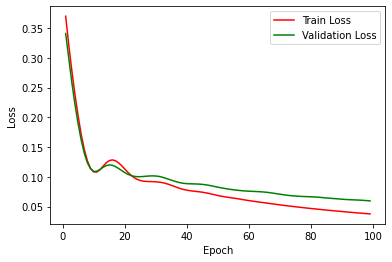

In [15]:
# Model results of said fitting, displayed in a plot
df_results = pd.DataFrame.from_dict(history.history)
df_results = df_results.iloc[1:,]
plt.plot(df_results['loss'], color='red', label=('Train Loss'))
plt.plot(df_results['val_loss'], color='green', label=('Validation Loss'))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


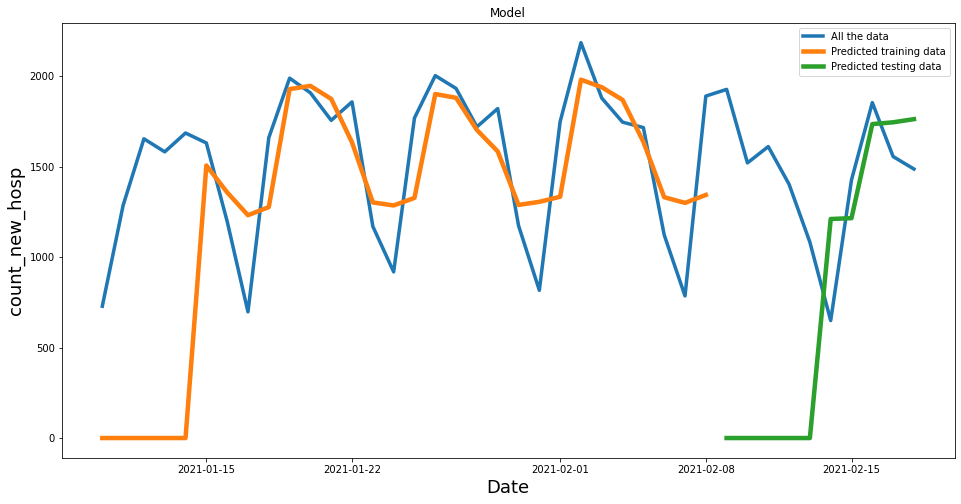

In [16]:
predict_data_train = df_2[:split_len]
predictions_x_train = np.zeros(step)
predictions_x_train = np.append(predictions_x_train, scaler_train_1.inverse_transform(model.predict([x_train_1, x_train_2])))
predict_data_train['predict_x_train'] = list(predictions_x_train)

predict_data_test = df_2[split_len:]
predictions_x_test = np.zeros(step)
predictions_x_test = np.append(predictions_x_test, scaler_test_1.inverse_transform(model.predict([x_test_1, x_test_2])))
predict_data_test['predict_x_test'] = list(predictions_x_test)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('count_new_hosp' ,fontsize=18)
plt.plot(df_2['count_new_hosp'],linewidth=3.5, label=('All the data'))
plt.plot(predict_data_train['predict_x_train'],linewidth=4.5, label=('Predicted training data'))
plt.plot(predict_data_test['predict_x_test'],linewidth=4.5, label=('Predicted testing data'))
plt.legend()

2. use all the data including vaccination

In [26]:
df_all = df[['count_new_hosp', 'n_cum_dose1']]
df_all = df_all.dropna()
df_all.head()

,count_new_hosp,n_cum_dose1
date,,
2020-03-19,2229.0,0
2020-03-20,1256.0,0
2020-03-21,1540.0,0
2020-03-22,1534.0,0
2020-03-23,2053.0,0


In [27]:
# split dataset to training dataset and test dataset
split_len = round((df_all.shape[0])*.92)  #in order to get more vaccine data in training data, we get half vaccine data in this split
training_data = df_all[:split_len]
testing_data = df_all[split_len:]
# training_data = training_data.values
# testing_data = testing_data['count_new_hosp'].values
print(training_data.shape)
print(testing_data.shape)
testing_data.head()

(310, 2)
(27, 2)


,count_new_hosp,n_cum_dose1
date,,
2021-01-23,1169.0,1074206
2021-01-24,918.0,1083419
2021-01-25,1768.0,1158865
2021-01-26,2002.0,1254821
2021-01-27,1931.0,1357450


In [28]:
from sklearn.preprocessing import MinMaxScaler

# build the data
step = 5
#normalise the data
scaler_train_1 = MinMaxScaler(feature_range=(0,1))
scaler_train_2 = MinMaxScaler(feature_range=(0,1))
scaler_test_1 = MinMaxScaler(feature_range=(0,1))
scaler_test_2 = MinMaxScaler(feature_range=(0,1))

training_data_1 = scaler_train_1.fit_transform(training_data[['count_new_hosp']])
training_data_2 = scaler_train_2.fit_transform(training_data[['n_cum_dose1']])
testing_data_1 = scaler_test_1.fit_transform(testing_data[['count_new_hosp']])
testing_data_2 = scaler_test_2.fit_transform(testing_data[['n_cum_dose1']])

x_train_1, y_train_1 = process(training_data_1, step)
x_train_2, y_train_2 = process(training_data_2, step)
x_test_1, y_test_1 = process(testing_data_1, step)
x_test_2, y_test_2 = process(testing_data_2, step)

(305, 5, 1)
(305, 1)
(305, 5, 1)
(305, 1)
(22, 5, 1)
(22, 1)
(22, 5, 1)
(22, 1)


In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from keras.layers.merge import concatenate
from keras.optimizers import Adam

# first input model
visible1 = Input(shape=(step, 1))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

# second input model
visible2 = Input(shape=(step, 1))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

In [25]:
adam = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(optimizer='adam', loss='mse')
history = model.fit([x_train_1, x_train_2], y_train_1, epochs=100, validation_data=([x_test_1, x_test_2], y_test_1))

Epoch 1/100
10/10 [==============================] - 1s 23ms/step - loss: 0.0047 - val_loss: 0.1249
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.1096
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.1223
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.1261
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.1144
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.1289
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.1214
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.1500
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.1017
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.1256
Epoch 11

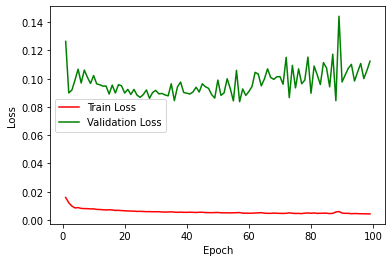

In [102]:
# Model results of said fitting, displayed in a plot
df_results = pd.DataFrame.from_dict(history.history)
df_results = df_results.iloc[1:,]
plt.plot(df_results['loss'], color='red', label=('Train Loss'))
plt.plot(df_results['val_loss'], color='green', label=('Validation Loss'))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


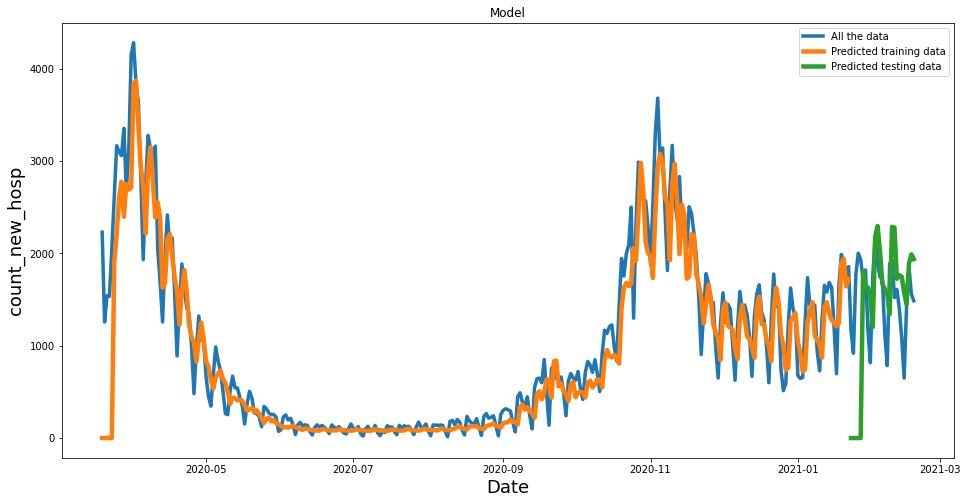

In [104]:
predict_data_train = df_all[:split_len]
predictions_x_train = np.zeros(step)
predictions_x_train = np.append(predictions_x_train, scaler_train_1.inverse_transform(model.predict([x_train_1, x_train_2])))
predict_data_train['predict_x_train'] = list(predictions_x_train)

predict_data_test = df_all[split_len:]
predictions_x_test = np.zeros(step)
predictions_x_test = np.append(predictions_x_test, scaler_test_1.inverse_transform(model.predict([x_test_1, x_test_2])))
predict_data_test['predict_x_test'] = list(predictions_x_test)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('count_new_hosp' ,fontsize=18)
plt.plot(df_all['count_new_hosp'],linewidth=3.5, label=('All the data'))
plt.plot(predict_data_train['predict_x_train'],linewidth=4.5, label=('Predicted training data'))
plt.plot(predict_data_test['predict_x_test'],linewidth=4.5, label=('Predicted testing data'))
plt.legend()